Houston Holman
4/2/23

Text Classification

In [27]:
#initialize data

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv('/kaggle/input/superheroes-nlp-dataset/superheroes_nlp_dataset.csv', header=0, usecols=[0,4,12,17,23,24], encoding='latin-1')
print('rows and columns:', df.shape)
print(df.head())

rows and columns: (1450, 6)
            name                                       history_text  \
0        3-D Man  Delroy Garrett, Jr. grew up to become a track ...   
1  514A (Gotham)  He was one of the many prisoners of Indian Hil...   
2         A-Bomb   Richard "Rick" Jones was orphaned at a young ...   
3             Aa  Aa is one of the more passive members of the P...   
4     Aaron Cash  Aaron Cash is the head of security at Arkham A...   

                                         superpowers        creator gender  \
0                  ['Super Speed', 'Super Strength']  Marvel Comics   Male   
1       ['Durability', 'Reflexes', 'Super Strength']      DC Comics    NaN   
2  ['Accelerated Healing', 'Agility', 'Berserk Mo...  Marvel Comics   Male   
3  ['Energy Absorption', 'Energy Armor', 'Energy ...      DC Comics   Male   
4          ['Weapon-based Powers', 'Weapons Master']      DC Comics   Male   

  type_race  
0     Human  
1       NaN  
2     Human  
3     Human  
4     

Note: I debated a lot on which columns from the dataset to include. I decided to focus on the columns that were more text heavy. Since the values were to be concatenated into one string to be sent as input, I made sure to choose columns whose values make sense outside the context of the column label. I originally made use of the column 'teams' which stated the team name of each hero. This resulted in very high accuracy scores (NN got 96%!) but I feel like that was cheating in a way, since teamnames were unique to each publisher. With the above columns, the models should have more of a challenge classifying the heroes instead of just seeing 'Avengers' and marking down 'Marvel'.

In [3]:
# text preprocessing

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# remove stopwords
stopwords = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stopwords)

# replace NaNs with default value of 'unknown'
df.fillna('unknown', inplace=True)

# remove all entries that are not marvel or dc
mask = (df['creator'] == 'Marvel Comics') | (df['creator'] == 'DC Comics')
df = df[mask]

Note: other heroes are removed because a majority of the creators only have a handful of heroes. This makes it near impossible for any of the models to learn enough to categorize these heroes. Limiting the dataset to only Marval and DC leaves about 1000 heroes out of the 1400, which is more than enough to work with

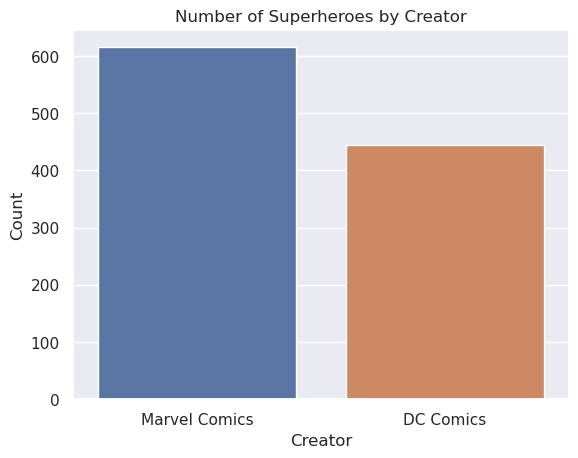

In [4]:
#draw graph

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

# Create bar graph
sns.countplot(x='creator', data=df)

# Set title and labels
plt.title('Number of Superheroes by Creator')
plt.xlabel('Creator')
plt.ylabel('Count')

# Show the plot
plt.show()

In [19]:
#combine text fields to create the input
X = df[['name', 'history_text', 'superpowers', 'gender', 'type_race']].apply(lambda x: '_'.join(x), axis=1)
print(X)

0       3-D Man_Delroy Garrett, Jr. grew up to become ...
1       514A (Gotham)_He was one of the many prisoners...
2       A-Bomb_ Richard "Rick" Jones was orphaned at a...
3       Aa_Aa is one of the more passive members of th...
4       Aaron Cash_Aaron Cash is the head of security ...
                              ...                        
1443    Yukio_Little is known about the early life of ...
1445    Zatanna_Zatanna is the daughter of adventurer ...
1447    Zoom (New 52)_Hunter Zolomon is better known a...
1448    Zoom_ Hunter Zolomon had a troubled relationsh...
1449    Zzzax_Zzzax was the product of an accident tha...
Length: 1059, dtype: object


In [20]:
#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df.creator, test_size=0.2, train_size=0.8, random_state=1234)

X_train.shape

(847,)

In [21]:
#apply tfidf vectorizer
X_train = vectorizer.fit_transform(X_train)  # fit and transform the train data
X_test = vectorizer.transform(X_test)        # transform only the test data

**Naive Bayes**

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# fit the model
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

# make predictions on the test data
pred = naive_bayes.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

print('accuracy score: ', accuracy_score(y_test, pred))
      
print('\nprecision score: ', precision_score(y_test, pred, average='macro', zero_division=1))

print('\nrecall score:', recall_score(y_test, pred, average='macro', zero_division=1))
      
print('\nf1 score: ', f1_score(y_test, pred, average = 'macro', zero_division=1))

print(classification_report(y_test, pred, zero_division=1))

[[ 63  21]
 [  2 126]]
accuracy score:  0.8915094339622641

precision score:  0.9131868131868132

recall score: 0.8671875

f1 score:  0.8810006101281269
               precision    recall  f1-score   support

    DC Comics       0.97      0.75      0.85        84
Marvel Comics       0.86      0.98      0.92       128

     accuracy                           0.89       212
    macro avg       0.91      0.87      0.88       212
 weighted avg       0.90      0.89      0.89       212



Result: 89.2% accuracy

This result shows that the Naive Bayes approach of focusing on word/phrase frequency is effective in this use case. If the model were to guess 'Marvel Comics' for every hero, the accuracy would be 60% which shows that the NB approach performs well. This may be due to writers from one company relying on the same phrasing of backstories and hero abilities.

**Logistical Regression**

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

#train
classifier = LogisticRegression(solver='lbfgs', class_weight='balanced')
classifier.fit(X_train, y_train)

# evaluate
pred = classifier.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, pred))
print('precision score: ', precision_score(y_test, pred, pos_label='Marvel Comics'))
print('recall score: ', recall_score(y_test, pred, pos_label='Marvel Comics'))
print('f1 score: ', f1_score(y_test, pred, pos_label='Marvel Comics'))
probs = classifier.predict_proba(X_test)
print('log loss: ', log_loss(y_test, probs))

accuracy score:  0.9292452830188679
precision score:  0.9448818897637795
recall score:  0.9375
f1 score:  0.9411764705882352
log loss:  0.4225980614416341


Result: 92.9% accuracy

This result is an improvement over NB. The approach of assigning weights to the input features provides a more accurate approach than just using frequencies, as it accounts for nuances such as the combination of certain features like hero name and backstory.

**Neural Network**

In [61]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(11, 6), random_state=1)
classifier.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(11, 6), random_state=1)

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
pred = classifier.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, pred))
print('precision score: ', precision_score(y_test, pred, pos_label='Marvel Comics'))
print('recall score: ', recall_score(y_test, pred, pos_label='Marvel Comics'))
print('f1 score: ', f1_score(y_test, pred, pos_label='Marvel Comics'))

accuracy score:  0.9339622641509434
precision score:  0.9318181818181818
recall score:  0.9609375
f1 score:  0.9461538461538462


Result: 93.4% accuracy

The neural network proves to be the best approach of the 3, most likely due to its deeper analysis of the input text through its use of multiple layers of hidden nodes. After lots of testing, I found that the 'adam' solver and a hidden layer size of (11, 6) performs the best for this dataset. 